# **Euler–Maruyama method**

기초적인 SDE solution  
${\displaystyle \,Y_{n+1}=Y_{n}+a(Y_{n},\tau _{n})\,\Delta t+b(Y_{n},\tau _{n})\,\Delta W_{n},}$

# ***The "FRKI" method (first-order Runge-Kutta method involving the Ito coefficient).***

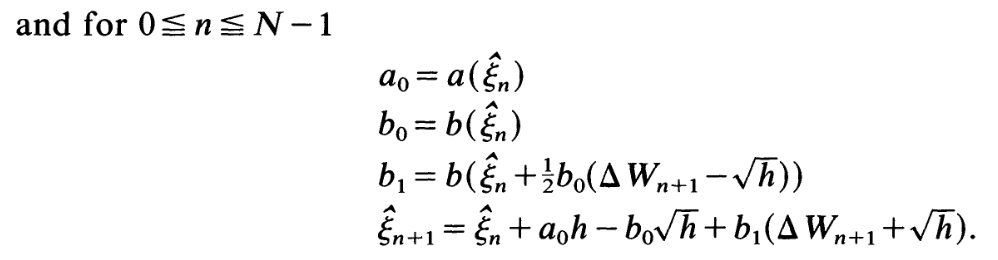


b텀에 해당되는 노이즈의 세기가 $\xi$에 영향을 주지 않는 경우 노의즈에 해당되는 텀은 사라지고 RKHG 방법으로 변하게 된다.

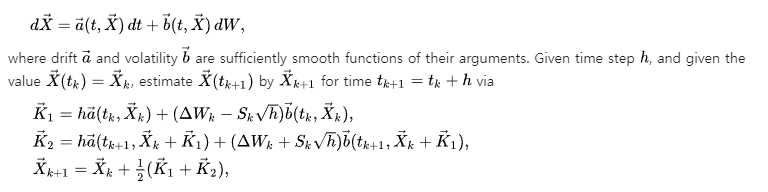  
[Runge–Kutta method (SDE)](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_(SDE))

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm.notebook import tqdm

In [206]:
# @jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice([-1,1],size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y



def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

In [207]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc




In [208]:
# @jit(nopython=True)
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

# @jit(nopython=True)
def Kuramoto_mf(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/N*np.sum(np.sin(theta_j - theta_i),axis=0)
    Theta[:N] = dtheta
    return Theta

# @jit(nopython=True)
def Kuramoto_mf_AR(Theta,t,omega,N,K,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto_AR(Theta,t,omega,N,K,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/N*np.sum(np.sin(theta_j - theta_i),axis=0) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta



In [209]:
N = 1000

theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=10)
omega = np.sort(omega)-np.mean(omega)
omega = np.ones(N)

In [210]:
K = 1
t_end = 1000
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 1.01
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))

theta_s = sol[th:,:N]
dtheta_s = sol[th:,N:2*N] 
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [251]:
db = 0.02
Ds = np.arange(0,2+db/2,db)
bs = np.arange(0,2+db/2,db)
len(Ds)
# Ds = np.linspace(0,2,10)
# bs = np.linspace(0,2,11)

101

In [252]:
th = len(t)//2
D_rij = []
D_sigmaij = []
for D in tqdm(Ds):
    D_rs = []
    D_sigmas = []
    for b in bs:        
        sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
        theta_s = sol[th:,:N]
        dtheta_s = sol[th:,N:2*N] 
        rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
        # rabs = rabs_[len(t)//2:]
        r = np.abs(rabs)
        sigma_phi = np.mean(rabs)
        sigma = np.abs(sigma_phi)
        psi = np.abs(sigma_phi)
        sigma,np.mean(r)
        D_rs.append(r)
        D_sigmas.append(sigma)
    D_rij.append(D_rs)
    D_sigmaij.append(D_sigmas)

  0%|          | 0/101 [00:00<?, ?it/s]

In [253]:
D_rij = np.array(D_rij)
D_sigmaij = np.array(D_sigmaij)
D_r_meanij = np.mean(D_rij,axis=2)

In [254]:
np.savez(f'db={db}',Ds=Ds,bs=bs,D_rij =D_rij,D_mrij=D_r_meanij,D_sij = D_sigmaij)

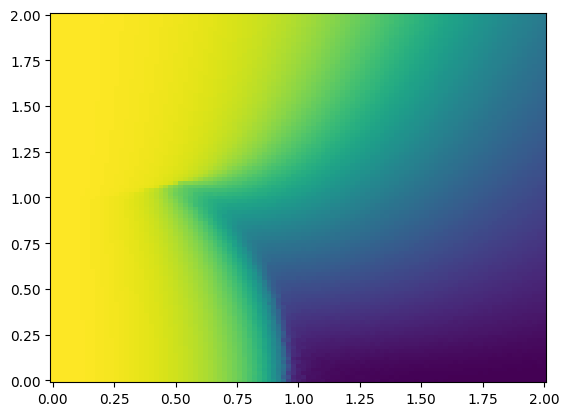

In [255]:
plt.pcolormesh(Ds,bs,D_r_meanij.T)

In [256]:
DD,BB = np.meshgrid(Ds,bs)

In [ ]:
Z = np.abs(D_sigmaij-D_r_meanij).T
# CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

CS  = plt.pcolormesh(Ds,bs,abs(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


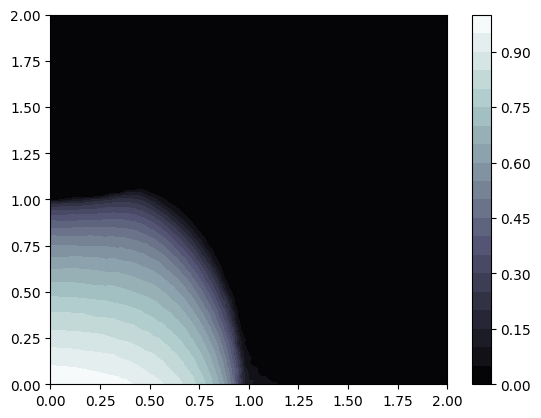

In [320]:
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

# CS  = plt.pcolormesh(Ds,bs,(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


In [259]:
theta_s = sol[:,:N]
dtheta_s = sol[:,N:2*N] 
rabs_ = np.mean(np.exp(theta_s.T*1j),axis=0)
rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)
sigma,np.mean(r)

(0.4288721064156325, 0.42948551530501594)

In [260]:
D_r_meanij = np.mean(D_rij,axis=2)

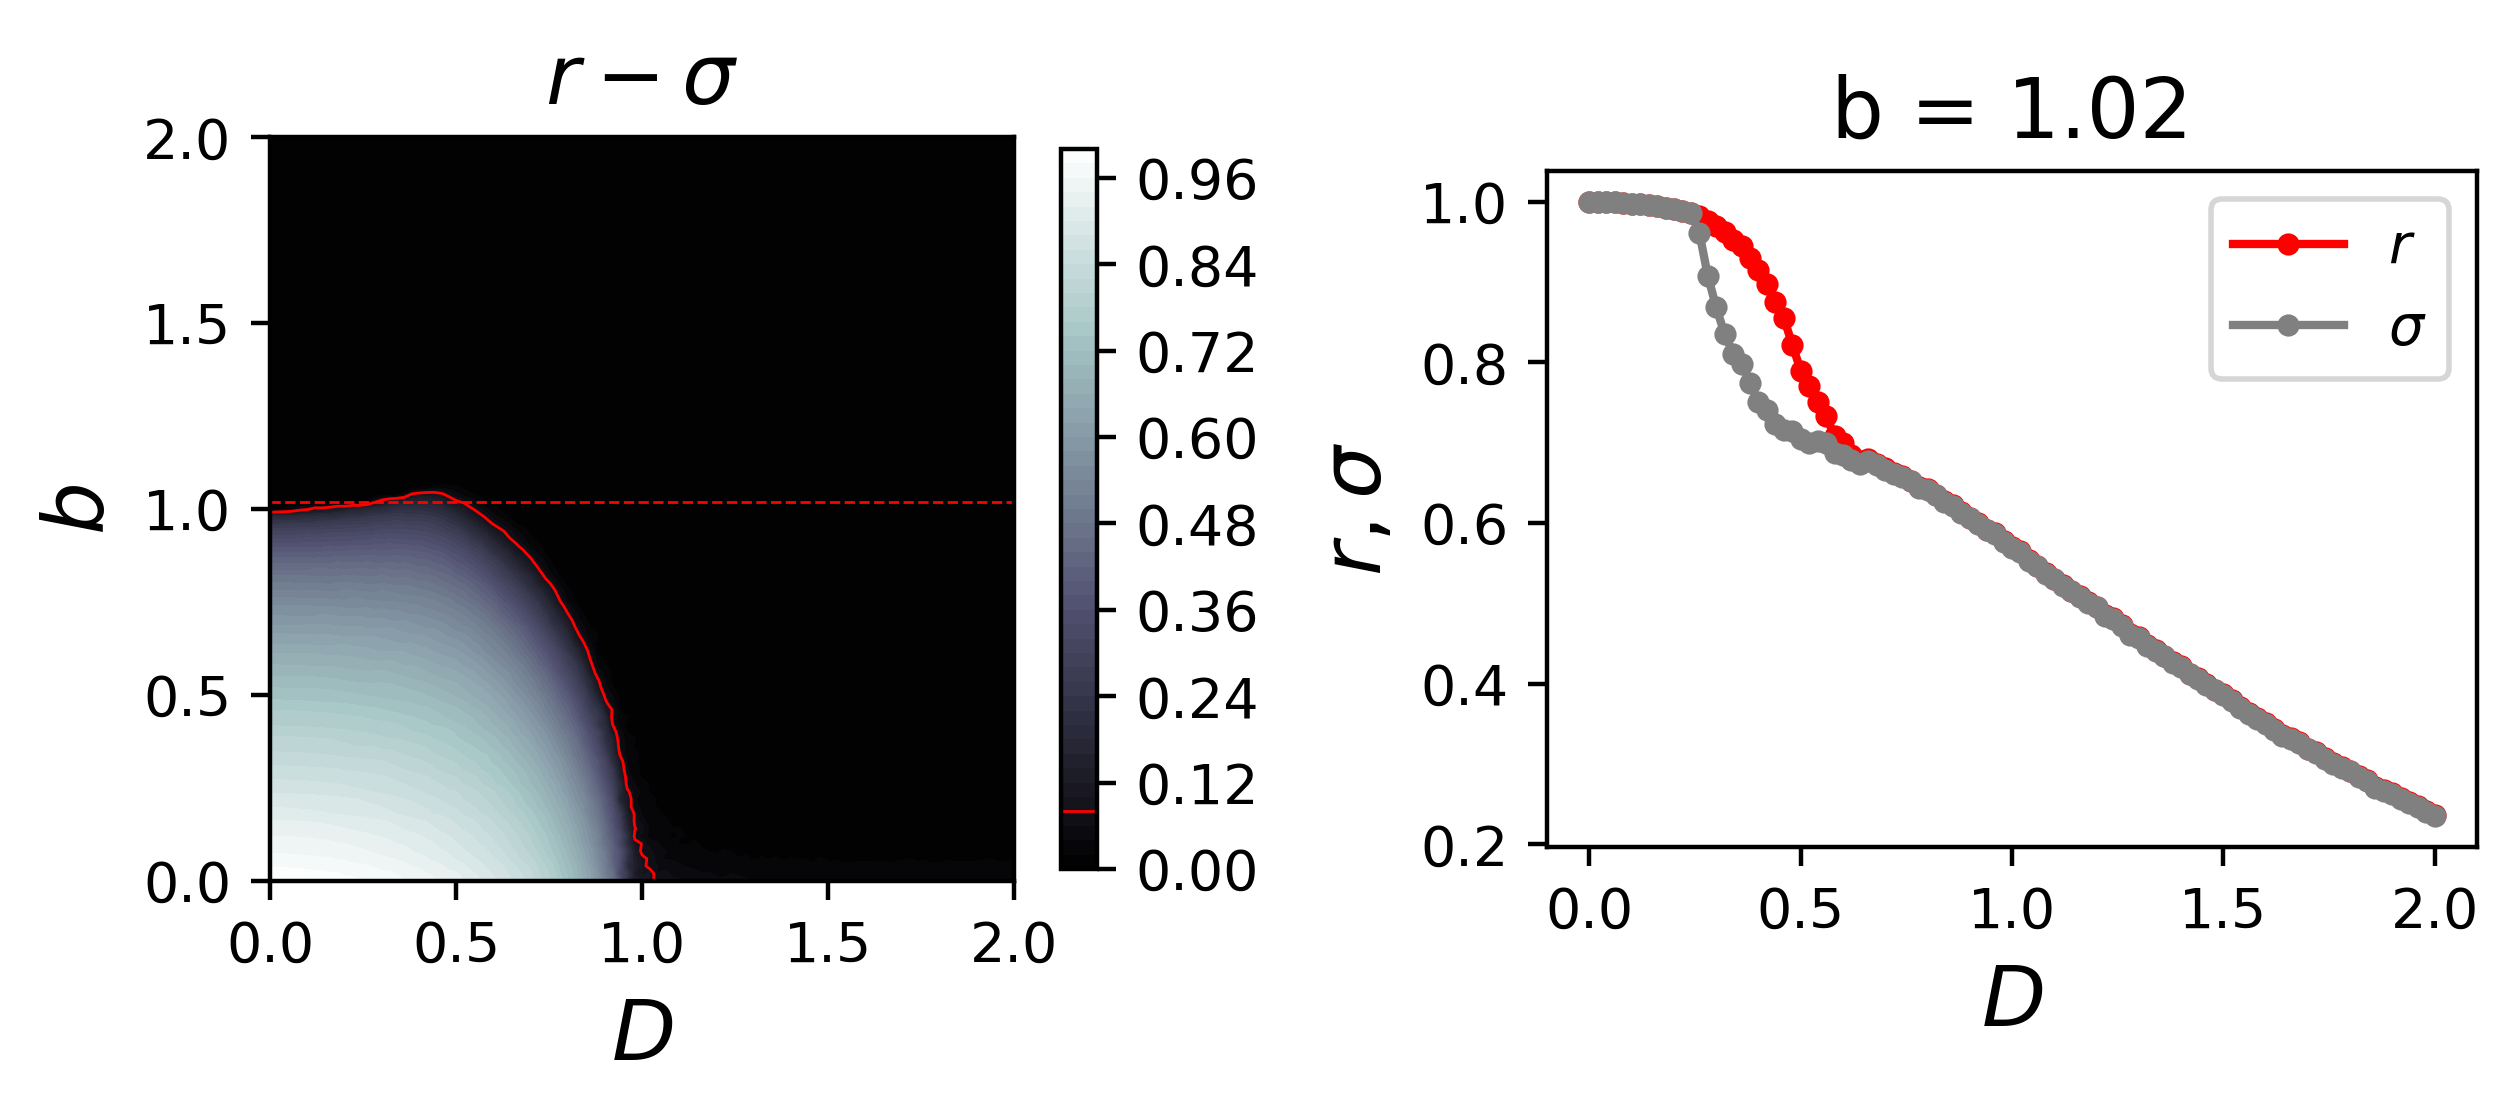

In [391]:
fig,(ax1,ax2) = plt.subplots(1,2,width_ratios=[1,1],dpi=400)
plt.sca(ax1)
b_idx = 51
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,50, cmap=plt.cm.bone)

CS2 = plt.contour(CS, levels=CS.levels[4:5],linewidths=0.5, colors='r')
cbar = plt.colorbar(CS,shrink=0.4)
plt.gca().set_aspect('1')
cbar.add_lines(CS2)
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$b$',fontsize=15)
plt.title(r'$r-\sigma$',fontsize=15)

plt.axhline(bs[b_idx],color='red',lw=0.5,ls='--')

plt.sca(ax2)

plt.plot(Ds,D_r_meanij[:,b_idx],'.-',color='red',label =r'$r$')
plt.plot(Ds,D_sigmaij[:,b_idx],'.-',color='gray',label =r'$\sigma$')
plt.gca().set_aspect('1.9')

plt.legend()
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$r,\sigma$',fontsize=15)
plt.title(f'b = {bs[b_idx]}',fontsize=15)

plt.tight_layout()
plt.show()

In [407]:
vphase = theta_s.T - t

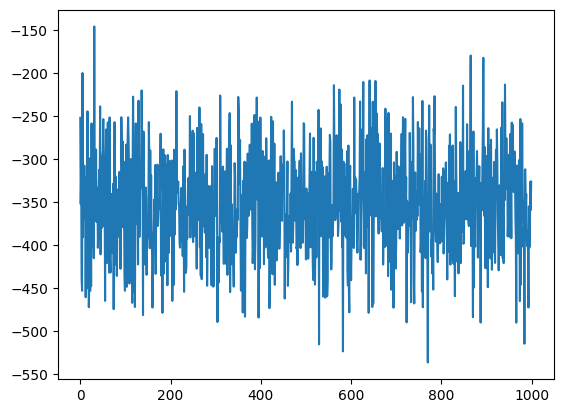

In [411]:
plt.plot(vphase[:,-1])

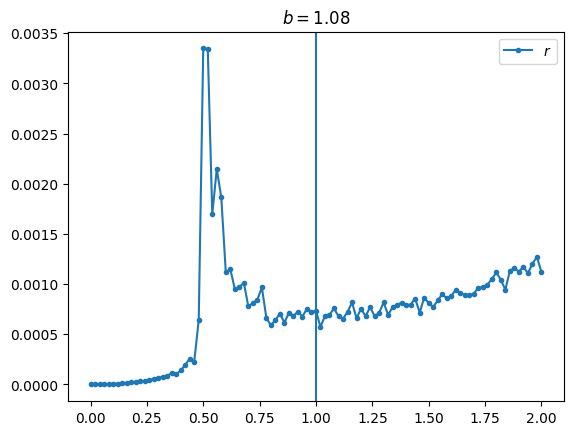

In [319]:
b_idx = 54
plt.plot(Ds,D_r_meanij[:,b_idx]-D_sigmaij[:,b_idx],'.-',label =r'$r$')
plt.title(rf'$b={bs[b_idx]}$')
# plt.plot(Ds,D_sigmaij[:,b_idx],'d-',color='gray',label =r'$\sigma$')
# plt.axhline(3/np.sqrt(N))
plt.axvline(1)
plt.legend()
# plt.plot(D_rij[:,5,-1])

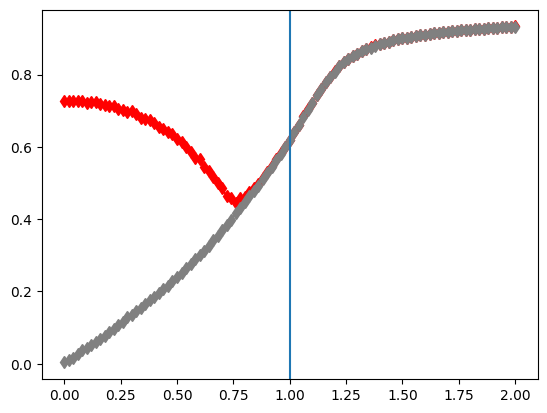

In [303]:
D_idx= 40
plt.plot(bs,D_r_meanij[D_idx,:],'d-',color='red')
plt.plot(bs,D_sigmaij[D_idx,:],'d-',color='gray')
plt.xlabel(r'$b$',fontsize=15)
plt.ylabel(r'$r,\sigma$',fontsize=15)
plt.title('b')
# plt.axhline(3/np.sqrt(N))
plt.axvline(1)
# plt.plot(D_rij[:,5,-1])

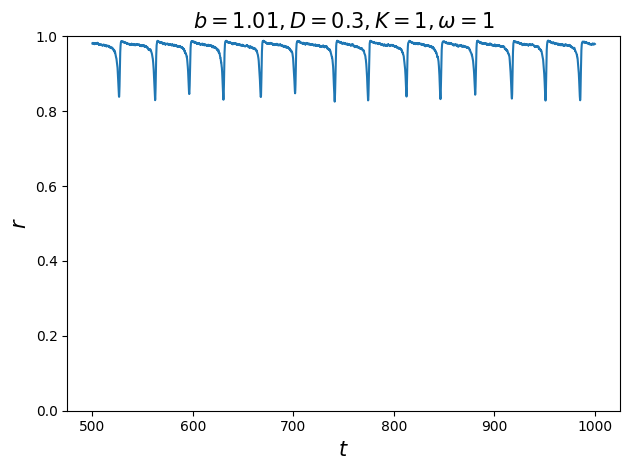

In [190]:
plt.plot(t[len(t)//2:],r)
plt.xlabel('$t$',fontsize=15)
plt.ylabel('$r$',fontsize=15)
plt.title(rf'$b={b},D={D},K={K},\omega=1$',fontsize=15)
plt.ylim(0.0,1)
plt.tight_layout()

In [191]:
h,b_ = np.histogram(np.sin(theta_s[len(t)//2,:]),bins=100)
hs = []
for i in range(2000):
    h,_ = np.histogram(np.sin(theta_s[len(t)//2+i,:]),bins=b_)
    hs.append(h)
hs = np.array(hs)
h

array([ 4,  8,  5,  5,  3,  7,  6,  6,  6,  1,  7,  8,  6,  5,  5,  6, 11,
        7,  9,  4,  5,  4,  5,  2,  5,  4,  6,  6,  5,  7,  6,  5,  8,  8,
        7,  7, 12,  7,  5,  7,  7,  5, 10,  7,  4, 10,  6, 13,  6,  9,  7,
        7,  6, 10,  8,  7,  3,  9,  7,  9,  8,  9,  6,  7,  8,  5,  8,  9,
        5,  9,  8, 10, 10,  6,  5,  3,  5,  4, 10,  9,  8,  6,  4,  2,  4,
        5,  6,  3,  7, 10,  4,  7,  5,  3,  1,  2,  6,  1,  5,  6])

In [192]:
dtheta_s = np.diff(theta_s/dt,axis=0)

In [193]:
dtheta_s = np.diff(theta_s,axis=1)
sum_time = 10
dtheta_c = np.cumsum(dtheta_s[:], axis=0)
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
diff_avg_dtheta = np.diff(avg_dtheta, axis=1)

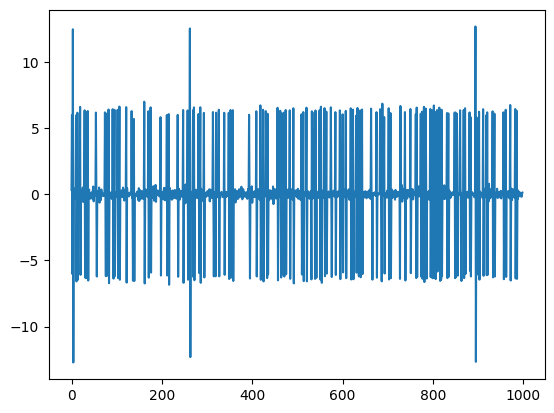

In [194]:
plt.plot(avg_dtheta[-1])

In [195]:
np.mean(avg_dtheta[-1])

0.0001789671814094307

In [196]:
avg_dtheta.shape

(9991, 999)

In [197]:
b_theta = np.arcsin(b_)

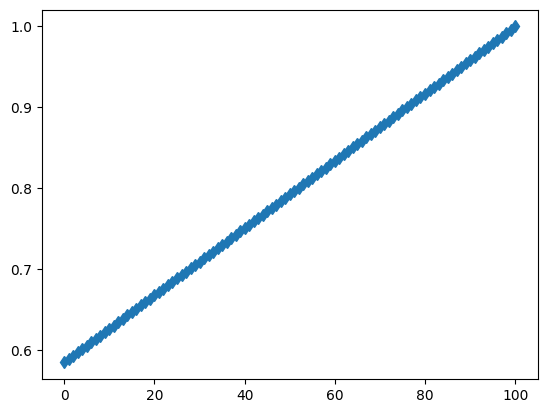

In [198]:
plt.plot(b_,'d')

In [199]:
A = (theta_s+np.pi)%(2*np.pi)-np.pi

In [200]:
h,b_ = np.histogram(np.linspace(-np.pi,np.pi),bins=200)
# h,b_ = np.histogram(A[len(t)//2,:],bins=100)
hs = []
for i in range(2000):
    h,_ = np.histogram(A[len(t)//2+i,:],bins=b_)
    hs.append(h)
hs = np.array(hs)
# b_theta = np.arcsin(b_)


In [201]:
b_theta = b_

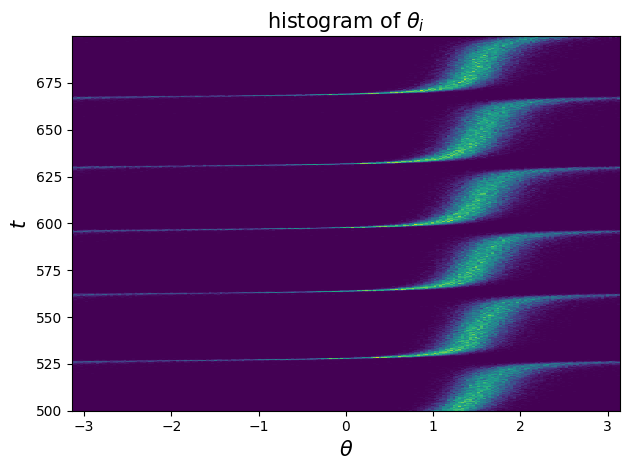

In [202]:
plt.pcolormesh(b_theta,t[len(t)//2:len(t)//2+2000],hs[1:])
plt.gca().set_aspect('auto')
plt.ylabel(r'$t$',fontsize=15)
plt.xlabel(r'$\theta$',fontsize=15)
plt.title(r'histogram of $\theta_i$',fontsize=15)
plt.xlim(-np.pi,np.pi)
plt.tight_layout()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          1.,   1.,   1.,   0.,   0.,   1.,   0.,   3.,   1.,   3.,   4.,
          3.,   2.,   3.,   2.,   2.,   4.,   3.,   2.,   3.,   4.,   4.,
          2.,   7.,   8.,   9.,  18.,  10.,   3.,  13.,  22.,  16.,  16.,
         20.,  19.,  24.,  21.,  27.,  19.,  29.,  27.,  32.,  27.,  24.,
         35.,  31.,  40.,  28.,  30.,  36.,  38.,  46.,  50.,  52.,  56.,
        112.]),
 array([0.9275491 , 0.92827361, 0.92899812, 0.92972262, 0.93044713,
        0.93117164, 0.93189615, 0.93262066, 0.93334517, 0.93406967,
        0.93479418, 0.93551869, 0.9362432 , 0.93696771, 0.93769222,
        0.93841672, 0.93914123, 0.93986574, 0.94059025, 0.94131476,
        0.94203927, 0.94276377, 0.94348828, 0.

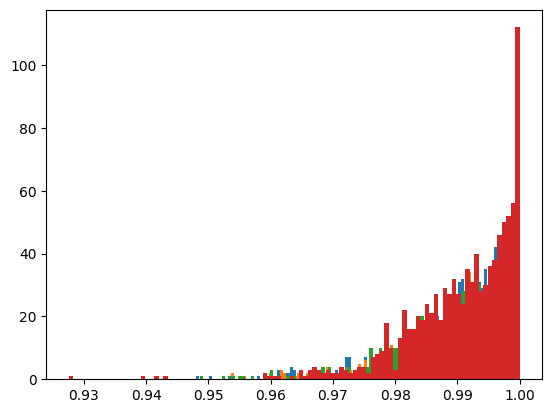

In [132]:

plt.hist(np.sin(theta_s[len(t)//2,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+10,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+20,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+30,:]),bins=100)

# phase velocity

In [1006]:
K = 1
t_end = 600
dt = 0.01
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 1.51
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))
th = len(t)//2
theta_s = sol[th:,:N]
dtheta_s = sol[th:,N:2*N]
t_ = t[th:] 
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [1007]:
theta_s[-1].shape

(1000,)

In [1008]:
v = (theta_s[-1] - theta_s[0])/(t_[-1] - t_[0])

In [1009]:
# plt.plot(v)
np.mean(v)
# plt.hist(v,bins=100)

-4.309196353852273e-05

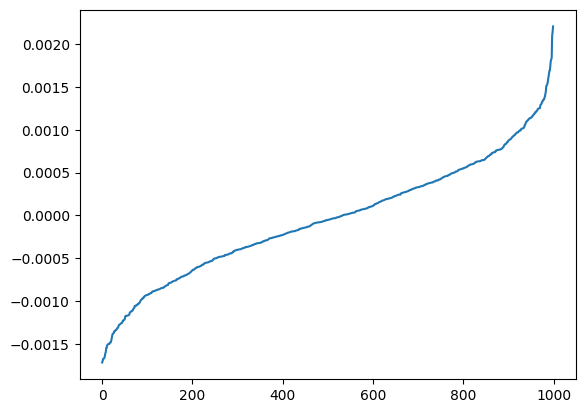

In [1010]:
# plt.hist(v,bins=100)
plt.plot(np.sort(v))

## Model network  
igraph  
networkx

In [523]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
# @jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice([-1,1],size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y

In [524]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc

In [1049]:
# @jit(nopython=True)
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

# @jit(nopython=True)
def Kuramoto_mf(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto(Theta,t,omega,N,K,mk,Aij):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0) 
    Theta[:N] = dtheta
    return Theta

# @jit(nopython=True)
def Kuramoto_mf_AR(Theta,t,omega,N,K,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto_AR(Theta,t,omega,N,K,mk,Aij,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0)  - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta

def get_order_parameter_ann(theta,N,mk,DEGT):
    ''' get theta and return r and theta'''
    rpsi = 1/(N*mk)*np.sum(DEGT*np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi



def Kuramoto_AMF_AR(Theta,t,omega,N,K,mk,DEGT,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter_ann(theta,N,mk,DEGT)
    dtheta = omega + K/mk*r*DEGT.flatten()*np.sin(psi - theta) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta


In [1026]:
# %timeit DegT.flatten()
%timeit DegT.reshape(-1,1)

88.5 ns ± 0.755 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [1174]:
mk = 5
N = 1000
p = mk/(N)
# G = nx.erdos_renyi_graph(N,p)
G = nx.barabasi_albert_graph(N,10)

In [1175]:
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
mk = Deg.mean()
mk

19.8

In [1176]:
mk

19.8

In [1177]:
# A = nx.adjacency_matrix(G)
Aij = A.todense()

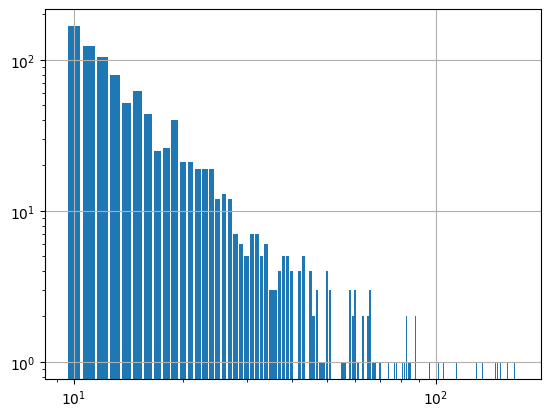

In [1186]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.loglog()
plt.grid()

In [1179]:
np.unique(degree_sequence, return_counts=True)

(array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  42,  43,  45,  46,  47,  48,  49,  50,
         51,  55,  56,  58,  59,  60,  61,  63,  65,  66,  67,  68,  70,
         74,  77,  78,  81,  82,  83,  84,  85,  88,  96, 102, 105, 114,
        130, 135, 146, 148, 151, 158, 165, 169]),
 array([168, 124, 105,  80,  52,  62,  44,  25,  26,  40,  21,  21,  19,
         19,  19,  12,  13,  12,   7,   6,   5,   7,   7,   5,   6,   3,
          3,   4,   5,   5,   4,   4,   5,   4,   2,   3,   1,   1,   4,
          3,   1,   1,   3,   2,   3,   1,   2,   2,   3,   1,   1,   1,
          1,   1,   1,   1,   1,   2,   1,   1,   2,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1]))

In [1180]:
N = 1000

theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=10)
omega = np.sort(omega)-np.mean(omega)
omega = np.ones(N)

In [1181]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 1.01
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))
th = len(t)//2
theta_s = sol[th:,:N]
dtheta_s = sol[th:,N:2*N] 
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [1182]:
sol = RKHG(Kuramoto_AMF_AR,theta_random,t,D, args=(omega,N,K,mk,DegT,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))
th = len(t)//2
theta_s = sol[th:,:N]
dtheta_s = sol[th:,N:2*N] 
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r2 = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma2 = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [1183]:
th = 0# len(t)//2

theta_s = sol[th:,:N]
dtheta_s = sol[th:,N:2*N] 
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [1173]:
np.mean(r[len(t)//2:])-sigma

0.06117232361931235

In [1118]:
A.shape

(1000, 1000)

In [1119]:
Aij = nx.adjacency_matrix(G)
Deg = Aij.sum(axis=1)
mk = Deg.mean()
mk

3.992

In [1120]:
rabsN = 1/(N*MD) * np.sum(Deg.reshape(-1,1)*np.exp(theta_s.T*1j) ,axis=0)
rN = np.abs(rabsN)
sigma_phi = np.mean(rabsN)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [1022]:
np.mean(rN) - sigma

2.456063895028837e-05

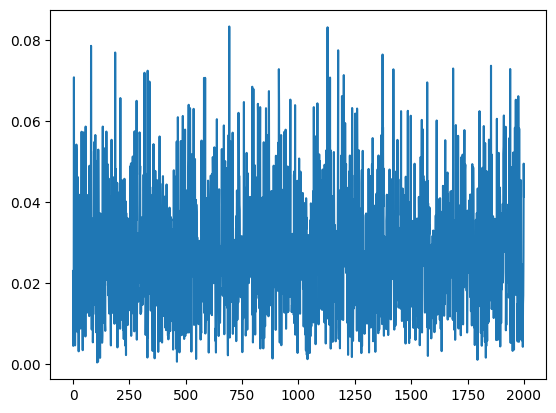

In [1184]:
# plt.plot(rN)
plt.plot(r)
# plt.plot(r2)

In [1146]:
h,b_ = np.histogram(np.linspace(-np.pi,np.pi),bins=200)
# h,b_ = np.histogram(A[len(t)//2,:],bins=100)
A = (theta_s+np.pi)%(2*np.pi)-np.pi
hs = []
for i in range(500):
    h,_ = np.histogram(A[i,:],bins=b_)
    hs.append(h)
hs = np.array(hs)
# b_theta = np.arcsin(b_)



In [1136]:
hs.shape

AttributeError: 'list' object has no attribute 'shape'

In [1137]:
len(hs[1:])

1000

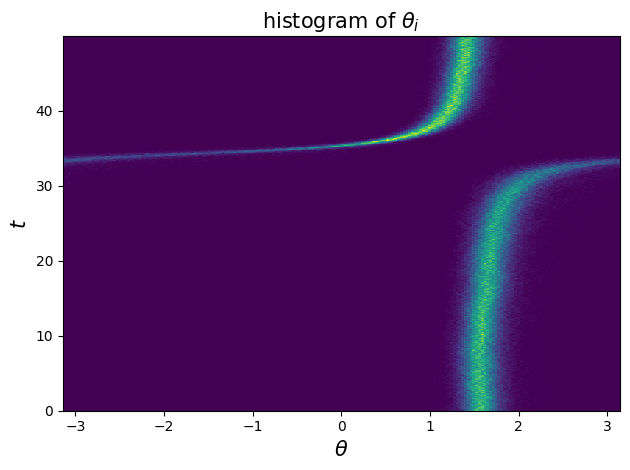

In [1147]:
b_theta = b_
plt.pcolormesh(b_theta,t[:500],hs[1:500])
plt.gca().set_aspect('auto')
plt.ylabel(r'$t$',fontsize=15)
plt.xlabel(r'$\theta$',fontsize=15)
plt.title(r'histogram of $\theta_i$',fontsize=15)
plt.xlim(-np.pi,np.pi)
plt.tight_layout()

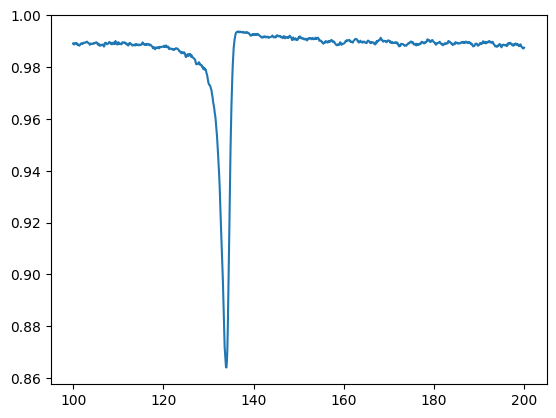

In [1148]:
t_ = t[th:] 
plt.plot(t_,r)

In [939]:
db = 0.02
Ds = np.arange(0,2+db/2,db)
bs = np.arange(0,2+db/2,db)
len(Ds)
# Ds = np.linspace(0,2,10)
# bs = np.linspace(0,2,11)

101

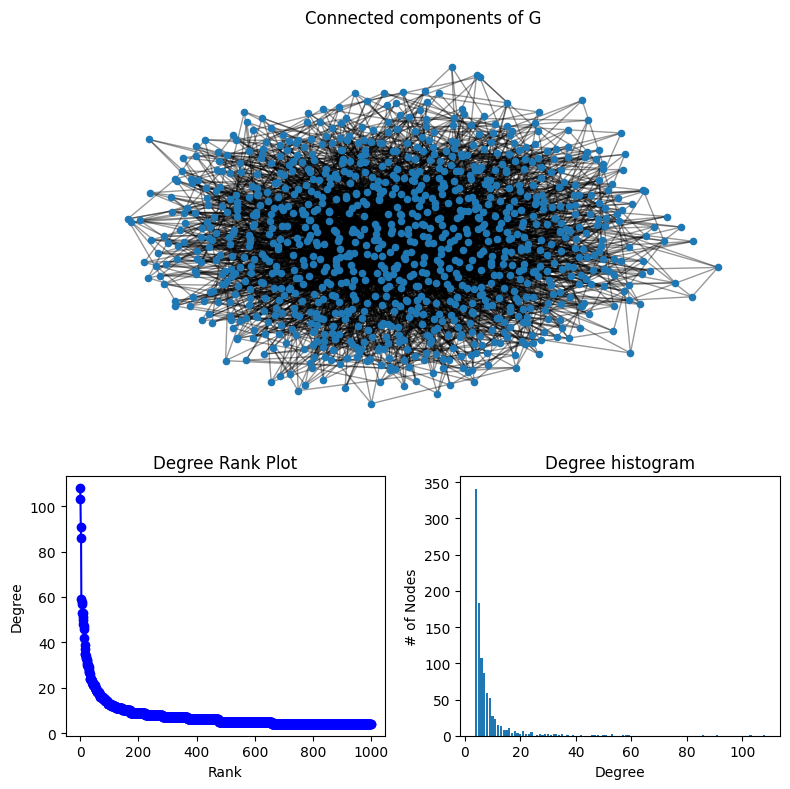

In [1149]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# G = nx.gnp_random_graph(N, p, seed=10374196)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [941]:
t.shape

(4001,)

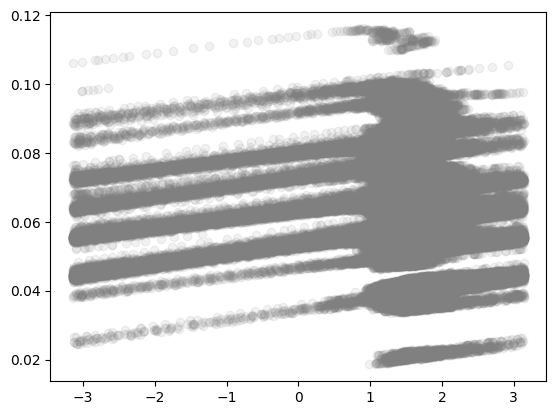

In [1101]:
idx = -10
A = (theta_s+np.pi)%(2*np.pi)-np.pi

for idx in range(-1000,-1):
    vtheta_s = (theta_s[idx] - theta_s[0]) /(t[idx]-t[0])
    plt.scatter(A[idx],vtheta_s,color='gray',alpha=0.1)

In [1150]:
sum_time =  100
theta_c = np.cumsum(theta_s[:], axis=0)
avg_theta = (theta_c[sum_time:]-theta_c[:-sum_time])/sum_time

In [1151]:
avg_dtheta_s = np.diff(avg_theta/dt,axis=0)

In [1152]:
A = (theta_s+np.pi)%(2*np.pi)-np.pi

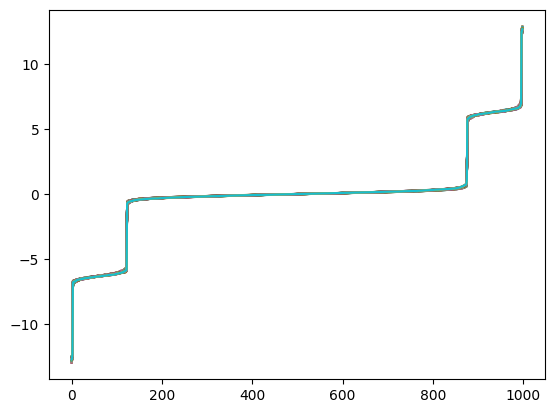

In [1172]:
plt.plot(np.sort(avg_dtheta[-100:].T,axis=0))

In [1168]:
# for i in range(-200,-1):
for i in range(1000):
    plt.scatter(A[-600-sum_time:-sum_time,i],avg_dtheta_s[-600:,i],alpha=0.3)
plt.axvline(np.pi/2)
plt.axvline(np.pi)
plt.axvline(-np.pi)
plt.axvline(-np.pi/2)

NotImplementedError: We have not yet implemented 1D sparse slices; please index using explicit indices, e.g. `x[:, [0]]`

In [900]:
avg_theta.T[1].shape

(3901,)

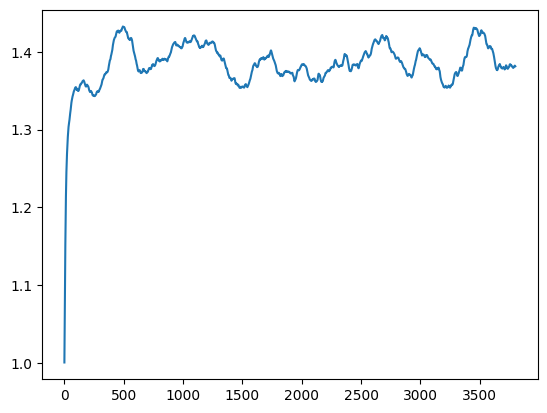

In [905]:
plt.plot(avg_theta.T[1])
# plt.plot(theta_s.T[1])

In [797]:
# np.cumsum(theta_s[:], axis=0)

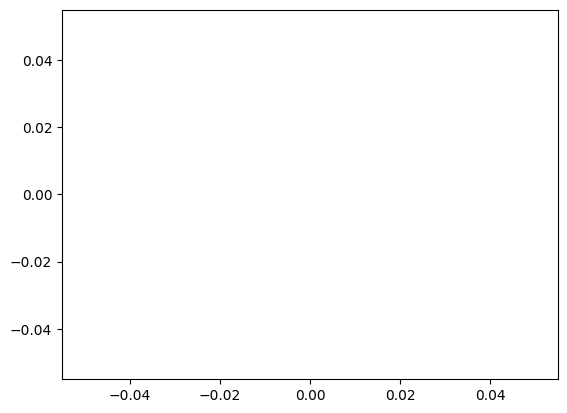

In [951]:
plt.scatter(dtheta_s[-1]2)

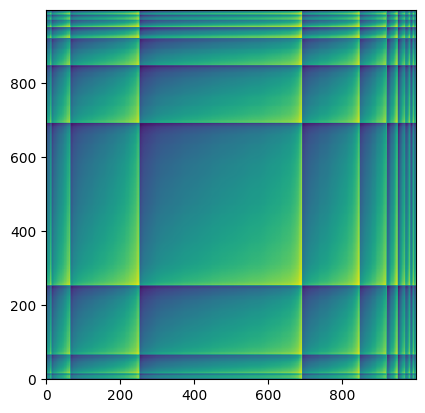

In [950]:
ti = theta_s[-1]
ti = np.sort(ti)
i,j = np.meshgrid(ti,ti)
plt.imshow(np.sin(i-j),origin='lower')

In [955]:
G.mean()

AttributeError: 'Graph' object has no attribute 'mean'

In [1052]:
mk = 5
N = 1000
p = mk/(N)
G = nx.erdos_renyi_graph(N,p)
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
MD = Deg.mean()

In [1059]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 1.51
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))

In [1187]:
db = 0.1
Ds = np.arange(0,1.5+db/2,db)
bs = np.arange(0,1.5+db/2,db)
len(Ds)

16

In [1189]:
th = len(t)//2

In [1190]:
th = len(t)//2
D_rij = []
D_sigmaij = []
for D in tqdm(Ds):
    D_rs = []
    D_sigmas = []
    for b in bs:        
        sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))
        theta_s = sol[th:,:N]
        dtheta_s = sol[th:,N:2*N] 
        rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
        # rabs = rabs_[len(t)//2:]
        r = np.abs(rabs)
        sigma_phi = np.mean(rabs)
        sigma = np.abs(sigma_phi)
        psi = np.abs(sigma_phi)
        sigma,np.mean(r)
        D_rs.append(r)
        D_sigmas.append(sigma)
    D_rij.append(D_rs)
    D_sigmaij.append(D_sigmas)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
D_rij = np.array(D_rij)
D_sigmaij = np.array(D_sigmaij)
D_r_meanij = np.mean(D_rij,axis=2)

In [ ]:
np.savez(f'mk = {mk} db={db} SF',Ds=Ds,bs=bs,D_rij =D_rij,D_mrij=D_r_meanij,D_sij = D_sigmaij,G = G)

In [ ]:
DD,BB = np.meshgrid(Ds,bs)

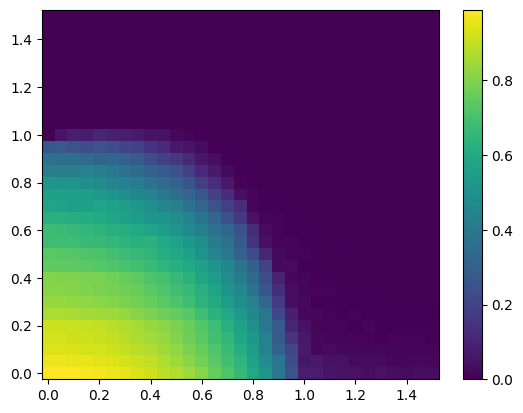

In [ ]:
Z = np.abs(D_sigmaij-D_r_meanij).T
# CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

CS  = plt.pcolormesh(Ds,bs,abs(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


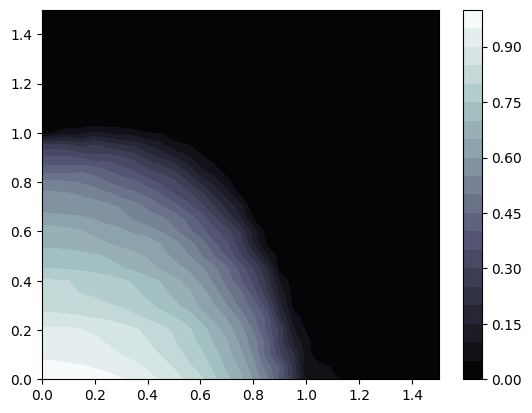

In [1066]:
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

# CS  = plt.pcolormesh(Ds,bs,(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


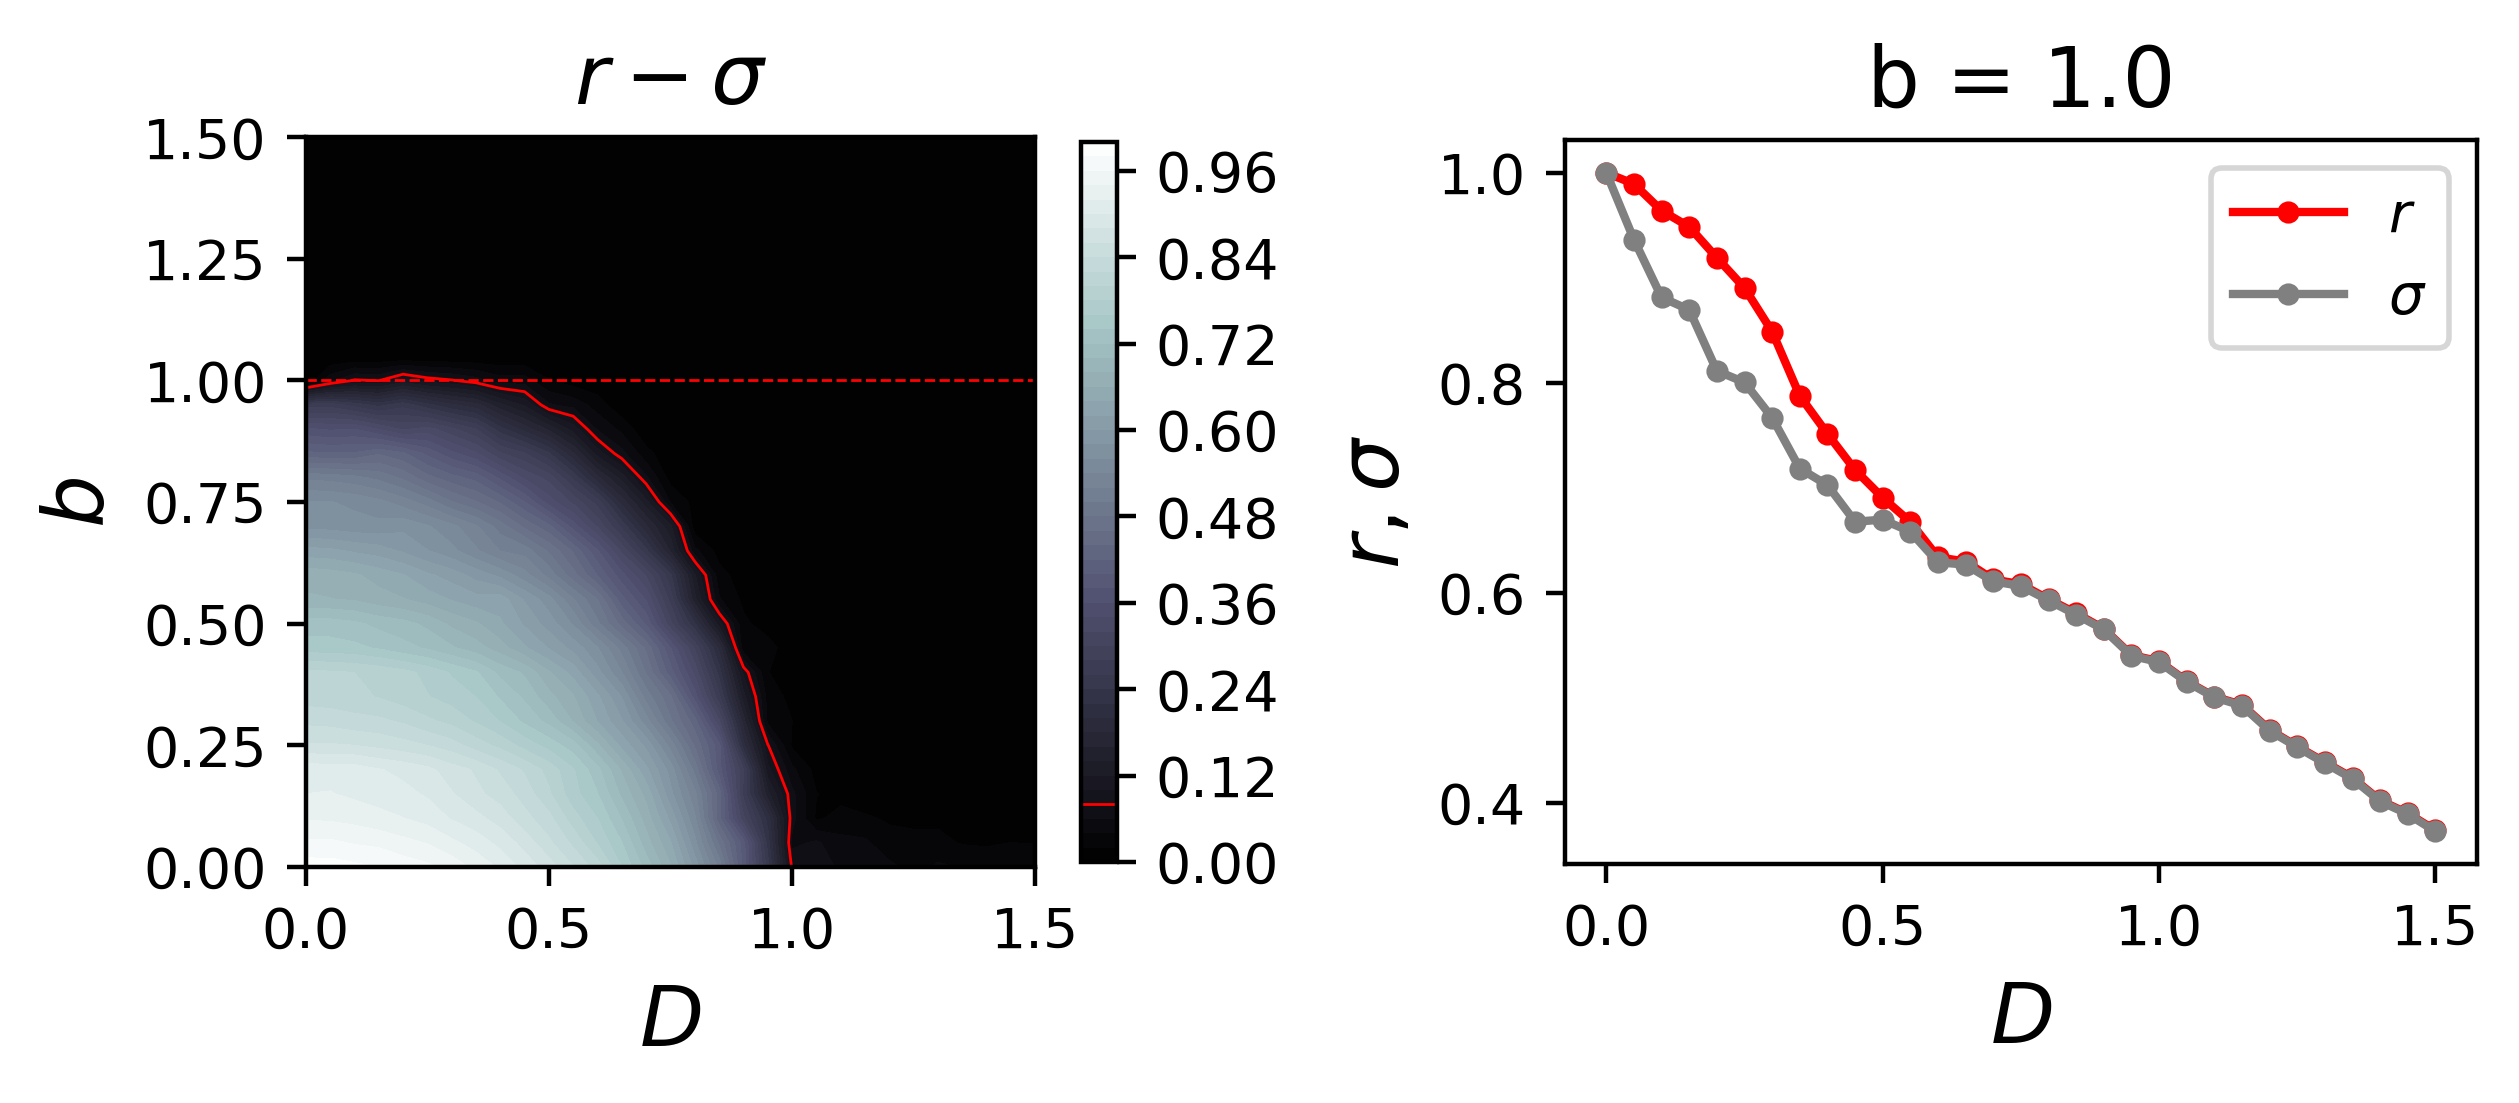

In [1077]:
fig,(ax1,ax2) = plt.subplots(1,2,width_ratios=[1,1],dpi=400)
plt.sca(ax1)
b_idx = 20
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,50, cmap=plt.cm.bone)

CS2 = plt.contour(CS, levels=CS.levels[4:5],linewidths=0.5, colors='r')
cbar = plt.colorbar(CS,shrink=0.4)
plt.gca().set_aspect('1')
cbar.add_lines(CS2)
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$b$',fontsize=15)
plt.title(r'$r-\sigma$',fontsize=15)

plt.axhline(bs[b_idx],color='red',lw=0.5,ls='--')

plt.sca(ax2)

plt.plot(Ds,D_r_meanij[:,b_idx],'.-',color='red',label =r'$r$')
plt.plot(Ds,D_sigmaij[:,b_idx],'.-',color='gray',label =r'$\sigma$')
plt.gca().set_aspect('1.9')

plt.legend()
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$r,\sigma$',fontsize=15)
plt.title(f'b = {bs[b_idx]}',fontsize=15)

plt.tight_layout()
plt.show()